<a href="https://colab.research.google.com/github/abhinavgairola/NLP_Timeseries/blob/main/Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#import requests
#from urllib.request import urlopen, Request
#from bs4 import BeautifulSoup

In [20]:
#url = "https://finviz.com/quote.ashx"
#def request(ticker):
#  payload = {"t":ticker,'start':'2020-01-01','end':'2020-05-01'}
#  response = requests.get(url,params=payload,headers={'user-agent':"Customer"})
#  if response.status_code == 200:
#    return response

In [21]:
#soup = BeautifulSoup(request('AMZN').text, 'html.parser')

In [22]:
#soup.find(id='news-table')

In [23]:
#! git clone https://github.com/Kriyszig/financial-news-data.git

In [24]:
#!git clone https://github.com/duynht/financial-news-dataset.git

In [25]:
#cd financial-news-data

In [26]:
#!python main.py

In [27]:
#df.to_parquet('/content/drive/My Drive/News.gzip',compression='gzip')

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import numpy as np
df = pd.read_parquet('/content/drive/My Drive/News.gzip')

In [30]:

df.head(2)

,Headline,Journalists,Date,Link,Article
0,Fed officials at odds on how long to keep rate...,[],"Tue Mar 2, 2010 9:35pm EST",http://www.reuters.com/article/2010/03/03/us-u...,NEW YORK (Reuters) - Top Federal Reserve offi...
1,Market finishes flat as Obama pushes regulation,[Edward Krudy],"Wed Mar 3, 2010 4:59pm EST",http://www.reuters.com/article/2010/03/03/us-m...,NEW YORK (Reuters) - U.S. stocks ended little...


In [31]:
Data_Article_Headline = df[['Date','Headline','Article']].sort_values(by='Date',ascending=False)
Data_Article_Article = df[['Date','Article']].sort_values(by='Date',ascending=False)

In [32]:
Data_Article_Article['Article'].head(2)

43749    FRANKFURT  (Reuters) - Goldman Sachs Chief Exe...
43731    NEW YORK  (Reuters) - U.S. mortgage applicatio...
Name: Article, dtype: object

In [33]:
import re 
import gensim
pattern = re.compile(r'[,\:,\',\"""",\,\.;]')
pattern_2 = re.compile(r'(text|quotebox)')
Article = []
#count = 0
for text in (Data_Article_Article.Article):
  text_2 = re.sub(pattern,'',text.lower())
  text_2 = re.sub(pattern_2,'',text_2)
  text_2 = re.sub('\W+',' ',text_2).strip()
  text_2 = re.sub('[()]', '', text_2)
  Article.append(text_2)
Data_Article_Article['Article_2']=Article

### 

In [34]:
Data_Article_Article['Article_2'].head(2)

43749    frankfurt reuters goldman sachs chief executiv...
43731    new york reuters us mortgage applications surg...
Name: Article_2, dtype: object

In [35]:
import spacy
spacy.prefer_gpu()

True

In [36]:

nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.Defaults.create_lemmatizer()
Data_Lemmatize = np.copy(Data_Article_Article['Article_2'])
for i,word in enumerate(Data_Lemmatize):
  temp = word.split()
  temp_2 = [lemmatizer.lookup(word) for word in temp]
  temp_2 = " ".join(temp_2)
  temp_2 = gensim.parsing.preprocessing.remove_stopwords(temp_2)
  Data_Lemmatize[i]=temp_2
Data_Article_Article['Lemmatize_Article'] = Data_Lemmatize
Data_Article_Article['Lemmatize_Article'].head(10)
#[lemmatizer.lookup(word) for word in Data_Lemmatize]

43749    frankfurt reuters goldman sachs chief executiv...
43731    new york reuters mortgage applications surged ...
31069    san francisco reuters texas instruments txnn r...
43720    washington reuters total consumer credit fell ...
43727    washington reuters president barack obama able...
31065                                                     
43740    new york reuters shares talbots tlbn rose 76 p...
31072    london reuters organization petroleum exportin...
43752    london reuters global financial crisis inevita...
43735    reuters kraft foods went public monday 167 bil...
Name: Lemmatize_Article, dtype: object

In [37]:
#print("Processing..")
#from tqdm import tqdm
#Vector = {}
#for Headline in tqdm(Data_Article_Headline['Lemmatize_hd']):
  #print(Headline)
#  doc = nlp(Headline)
  #print("Translating the Headline {} and vector shape is {}".format(Headline, doc.vector.shape))
#  Vector[Headline]=doc.vector
import shlex
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
List_for_Gensim = []
for article in Data_Article_Article['Lemmatize_Article']:
  List_for_Gensim.append(shlex.split(article))

data_for_training = list(tagged_document(List_for_Gensim)) 
data_for_training

[TaggedDocument(words=['frankfurt', 'reuters', 'goldman', 'sachs', 'chief', 'executive', 'lloyd', 'blankfein', 'urged', 'policymakers', 'keen', 'rebuild', 'confidence', 'financial', 'markets', 'refrain', 'creating', 'designed', 'solely', 'protecting', '100', 'year', 'stormalthough', 'economic', 'shocks', 'wake', 'collapse', 'lehman', 'brothers', 'year', 'ago', 'bring', 'natural', 'desire', 'wholesale', 'reform', 'taking', 'risk', 'completely', 'cost', 'economic', 'growth', 'blankfein', 'said', 'know', 'economic', 'history', 'innovation', 'new', 'industries', 'new', 'jobs', 'result', 'require', 'risk', 'taking', 'said', 'remarks', 'prepared', 'delivery', 'banking', 'conference', 'germanys', 'financial', 'capital', 'acknowledged', 'financial', 'industry', 'let', 'growth', 'complexity', 'new', 'instruments', 'outstrip', 'economic', 'social', 'utility', 'operational', 'capacity', 'manage', 'reforms', 'aim', 'retain', 'economically', 'viable', 'attributes', 'markets', 'mitigating', 'systemi

In [38]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [45]:
Data_Vectors = np.empty([300,len(data_for_training)])
for article, count in (data_for_training):
  Data_Vectors[:,count[0]] = model.docvecs[count[0]]
print(Data_Vectors.shape)

(300, 106494)


In [ ]:
Data_Vectors

In [46]:
Data_Frame = pd.DataFrame(data=Data_Vectors, columns=Data_Article_Article['Article_2'])
Data_Frame.head(2)

Article_2,frankfurt reuters goldman sachs chief executive lloyd blankfein urged policymakers keen to rebuild confidence in financial markets to refrain from creating a system designed solely around protecting us from the 100 year stormalthough the economic shocks in the wake of the collapse of lehman brothers almost a year ago bring about a natural desire for wholesale reform taking risk completely out of the system will be at the cost of economic growth blankfein said we know from economic history that innovation and the new industries and new jobs that result from it require risk taking he said in remarks prepared for delivery at a banking conference in germanys financial capital he acknowledged that the financial industry had let the growth and complexity of new instruments outstrip their economic and social utility as well as the operational capacity to manage them but reforms should aim to retain the economically viable attributes of markets while mitigating systemic risk by introducing the right infrastructure and incentives he said goldman supports a move to bring derivatives out of the so called shadow banking world by trading them on exchanges and clearing the trades via centralized clearing houses this would increase transparency for the products that are mostly traded bilaterally and force market participants to enforce margin requirements he added this will do more to enhance price discovery and reduce systemic risk than perhaps any specific rule or regulation blankfein said banks should also seek to use standardized rather than customized products whenever possible he said adding that customized derivatives should need higher capital requirements some aspects of the market such as credit default swaps were good blankfein said blankfein suggested that regulators ensure that exposures of a financial institution should be reflected on their balance sheet abolishing off balance sheet investment vehicles he urged financial firms to use fair value accounting methods to measure potential exposures by forcing financial institutions to recognize losses immediately risks to the system would become visible sooner instead positions were not visible so they were often ignored as were the risks until the losses grew to a point that solvency became an issue blankfein told bankers regulators needed to be more proactive in talking with market participants about where they see concentrations in risk and to improve coordination on a national and international level blankfein said turf battles between regulators shouldnt be allowed to overwhelm a focus on whats in the systems best interest blankfein said anger over compensation was in many respects understandable and appropriate blankfein said adding that goldman had a clawback tool which let the firm get back some of the bonuses paid if reputational or financial damage ensued multi year guaranteed employment contracts should be banned entirely the use of these contracts unfortunately is a common practice in our industry blankfein said multi year contracts are bad for the long term interests of our industry and the financial system he said adding that bankers need to do a better job of understanding when incentives begin to work against the public interest,san francisco reuters texas instruments inc txnn raised its forecast for third quarter earnings per share on wednesday expecting to ride a gradual recovery in the global semiconductor industrywe are expecting stronger revenue now in the third quarter in every one of our segments than what we had been expecting back in july said head of investor relations and vice president ron slaymaker on a conference call the highest sequential growth we would expect to be in our analog segment he said adding that wireless would also grow but at a slower pace slaymaker declined to predict that end demand was improving but said tis customers appeared to be ramping up production expectations had been for the overall semiconductor industry to begin 

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [47]:
ke=list(Data_Frame.keys())
Data_Frame[ke[0]].shape
Data_Frame


Article_2,frankfurt reuters goldman sachs chief executive lloyd blankfein urged policymakers keen to rebuild confidence in financial markets to refrain from creating a system designed solely around protecting us from the 100 year stormalthough the economic shocks in the wake of the collapse of lehman brothers almost a year ago bring about a natural desire for wholesale reform taking risk completely out of the system will be at the cost of economic growth blankfein said we know from economic history that innovation and the new industries and new jobs that result from it require risk taking he said in remarks prepared for delivery at a banking conference in germanys financial capital he acknowledged that the financial industry had let the growth and complexity of new instruments outstrip their economic and social utility as well as the operational capacity to manage them but reforms should aim to retain the economically viable attributes of markets while mitigating systemic risk by introducing the right infrastructure and incentives he said goldman supports a move to bring derivatives out of the so called shadow banking world by trading them on exchanges and clearing the trades via centralized clearing houses this would increase transparency for the products that are mostly traded bilaterally and force market participants to enforce margin requirements he added this will do more to enhance price discovery and reduce systemic risk than perhaps any specific rule or regulation blankfein said banks should also seek to use standardized rather than customized products whenever possible he said adding that customized derivatives should need higher capital requirements some aspects of the market such as credit default swaps were good blankfein said blankfein suggested that regulators ensure that exposures of a financial institution should be reflected on their balance sheet abolishing off balance sheet investment vehicles he urged financial firms to use fair value accounting methods to measure potential exposures by forcing financial institutions to recognize losses immediately risks to the system would become visible sooner instead positions were not visible so they were often ignored as were the risks until the losses grew to a point that solvency became an issue blankfein told bankers regulators needed to be more proactive in talking with market participants about where they see concentrations in risk and to improve coordination on a national and international level blankfein said turf battles between regulators shouldnt be allowed to overwhelm a focus on whats in the systems best interest blankfein said anger over compensation was in many respects understandable and appropriate blankfein said adding that goldman had a clawback tool which let the firm get back some of the bonuses paid if reputational or financial damage ensued multi year guaranteed employment contracts should be banned entirely the use of these contracts unfortunately is a common practice in our industry blankfein said multi year contracts are bad for the long term interests of our industry and the financial system he said adding that bankers need to do a better job of understanding when incentives begin to work against the public interest,san francisco reuters texas instruments inc txnn raised its forecast for third quarter earnings per share on wednesday expecting to ride a gradual recovery in the global semiconductor industrywe are expecting stronger revenue now in the third quarter in every one of our segments than what we had been expecting back in july said head of investor relations and vice president ron slaymaker on a conference call the highest sequential growth we would expect to be in our analog segment he said adding that wireless would also grow but at a slower pace slaymaker declined to predict that end demand was improving but said tis customers appeared to be ramping up production expectations had been for the overall semiconductor industry to begin 

In [49]:
ke= list(Data_Frame.keys())
import numpy as np
#import cupy as cp

In [51]:
ke = list(Data_Frame.keys())
#for i in ke:
#  Vector[i] = cp.asnumpy(Vector[i])

In [ ]:
#Headlines_to_vector = pd.DataFrame(Vector)

In [ ]:
#Headlines_to_vector.head(5)

In [52]:
Data_Frame_transposed = Data_Frame.T

In [ ]:
#Data_Article_Headline[Data_Article_Headline.Headline.str.contains('Goldman')].sort_values(by='Date')

In [53]:
#Headlines_to_vector.to_numpy()
Data_Frame_transposed

0    ...       299
Article_2                                                     ...          
frankfurt reuters goldman sachs chief executive... -1.110417  ... -1.704981
new york reuters us mortgage applications surge... -0.270196  ...  0.403015
san francisco reuters texas instruments inc txn...  0.011746  ... -0.466401
washington reuters total us consumer credit fel...  0.071823  ...  0.632325
washington reuters president barack obama will ...  0.793629  ...  0.573651
...                                                      ...  ...       ...
new york reuters us employment recorded a secon...  0.602026  ... -1.392580
washington reuters white house economist austan...  0.184706  ...  0.512071
london reuters nasdaq omx and intercontinentale... -0.270480  ... -0.209206
new york reuters the us manufacturing sector gr... -0.131761  ... -0.169526
new york reuters ireland was put on review for ... -0.445915  ...  0.059428

[106494 rows x 300 columns]

In [ ]:
from sklearn.cluster import KMeans
#import numpy as np
x_cols = Data_Frame_transposed.to_numpy()
S =[]
cluster_assignment = {}
for k in range(2,37):
    print("This is cluster{}".format(k))
    model_Kmeans = KMeans(n_clusters=k)
    fitted = model_Kmeans.fit(x_cols)
    predict = fitted.predict(x_cols)## points belonging to which cluster
    centers = model_Kmeans.cluster_centers_
    center_cluster = centers[predict]## To which cluster center belongs too
    S.append(np.sum((x_cols-center_cluster)**2))## Get the SS for the current value of 'k'
    cluster_assignment[str(k)]=predict
#plt.figure(figsize=(10,5))
#plt.plot(range(2,10),S)
#plt.ylabel(r'Sum-of-squares error')
#plt.xlabel(r'Number of clusters (K)')
#plt.show()

This is cluster2
This is cluster3
This is cluster4
This is cluster5
This is cluster6
This is cluster7
This is cluster8
This is cluster9
This is cluster10


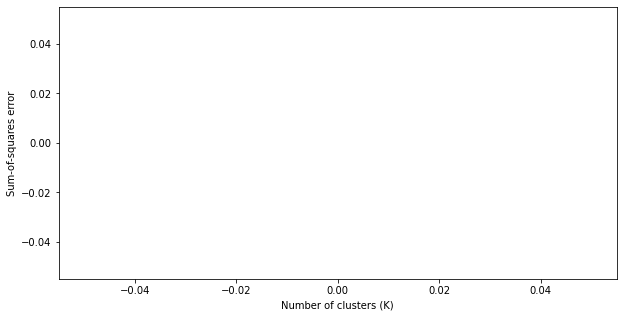

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
#plt.axvline(25,color='red')
plt.plot(range(2,len(S)+2),S)
plt.ylabel(r'Sum-of-squares error')
plt.xlabel(r'Number of clusters (K)')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(x_cols)
kmeans = KMeans(n_clusters=10)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [ ]:
plt.figure(figsize=(15,10))
centers = kmeans.cluster_centers_
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=0.2, cmap='jet')
plt.scatter(centers[:,0],centers[:,1],c='black',s=45,marker='*')
#help(plt.scatter)

### Lets extract the labels and map them to the news headlines. The ordering of the vectors is preserved by the kmeans labels. Considering this we can use the index of the Headlines_to_vector and zip them with labels. But first use an aggressive clustering with more clusters.

In [ ]:
kmeans = KMeans(n_clusters=37)
fitted = kmeans.fit(x_cols)
prediction = kmeans.predict(x_cols)

In [ ]:
result = zip(kmeans.labels_,Headlines_to_vector_transposed.index )

In [ ]:
DataFrame = pd.DataFrame({'label':kmeans.labels_,'sentence':Headlines_to_vector_transposed.index})

In [ ]:
DataFrame[DataFrame['label']==1]['sentence']

In [ ]:
DataFrame_2 = pd.DataFrame(dict(result),index=[0])

In [ ]:
melt=DataFrame_2.melt()

In [ ]:
Headlines_to_vector_transposed.to_csv('/content/drive/My Drive/Headlines.csv')

In [ ]:
DataFrame.to_csv('/content/drive/My Drive/label_sentence_news_37.csv')

In [ ]:
articles_cl = DataFrame[DataFrame['label']==2]['sentence'].values
Date = np.copy(articles_cl)
for i, j in enumerate(articles_cl):
  Date[i]= (Data_Article_Headline[Data_Article_Headline['Lemmatize_hd']==j]['Date']).values[0]
Date

In [ ]:
cluster_5 =pd.DataFrame({"Headline":DataFrame[DataFrame['label']==2]['sentence']})
cluster_5['Date']=pd.to_datetime(Date)
cluster_5.sort_values(by='Date')

In [ ]:
cluster_5
columns_titles = ["Date","Headline"]
cluster_5=cluster_5.reindex(columns=columns_titles)
cluster_5['Date'] = cluster_5.Date.dt.strftime('%Y-%m-%d')
cluster_5

In [ ]:
cluster_5.sort_values(by='Date')

In [ ]:
!pip install yfinance

In [ ]:

import yfinance as yf
import pandas as pd
msft = yf.Ticker("MSFT")

# get stock info
print(msft.info)